### Install Libs

In [1]:
!pip install transformers==4.31.0

In [2]:
!pip install datasets

In [3]:
import pandas as pd
import random as rn
import numpy as np
import os
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/Satria Data pt 2/Semifinal/'
seed_value = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

### Preprocess data

In [5]:
buzz_df_sample = pd.read_csv('/content/drive/MyDrive/Satria Data pt 2/Semifinal/Dataset/dav/buzz_df_sample_balanced.csv')
non_buzz_df_sample = pd.read_csv('/content/drive/MyDrive/Satria Data pt 2/Semifinal/Dataset/dav/non_buzz_df_sample_balanced.csv')

buzz_df_sample['label'] = 1
non_buzz_df_sample['label'] = 0

df_train = pd.concat([buzz_df_sample, non_buzz_df_sample])
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_train

,content,created_at,username,tcode,num_retweets,frn_cnt,flw_cnt,sts_cnt,loc,lst_cnt,lang,appearance_count,nama_re,label
0,mahasiswa ngajak debat di jalanan? pilih ganja...,2024-01-03 11:33:50+00:00,@gFldz8594a1/3rwZT40ovrELxMrSQ88OK94V0gw0Bos=,mention,0,90.000000,26.000000,1153.000000,PANGKALPINANG,0.000000,id,1,-,1
1,"betul top, bersama pbowogbran yespasti rakyat ...",2024-01-20 12:12:34+00:00,@hheI7wQBnWCiwxRLDt+NwDuvRZSS98LkJFqqbZl5iZk=,reply,0,21.000000,9.000000,94.000000,-,0.000000,id,1,-,0
2,"pemilu bukan hanya tentang memilih, tapi juga ...",2024-01-21 05:10:13+00:00,@Vdkp2WMtFHaJbA965/Uod3I/gZENqoPcbRvMgezvfwc=,mention,0,0.000000,9.500000,5741.000000,-,0.000000,id,2,-,1
3,ganjar-mahfud membangun kepercayaan generasi m...,2024-01-04 09:22:17+00:00,@7hXgNNxvPb7+D1i+GbLEuSqGVgZ7RoouD0gyRcIymaE=,mention,0,21.000000,10.000000,1048.000000,Jakarta Barat,0.000000,id,1,-,1
4,rt aslinya acara model desak anies itu bukan m...,2024-01-24 04:36:05+00:00,@5RYtLW+5dh+Qgme5cLz/YI2n2/WzEd19VvyPzDzHxww=,rt,4,552.333333,2382.333333,20532.666667,-,1.000000,id,3,munierlicious,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,gaspoll terus buat ganjar-mahfud,2024-01-09 05:02:28+00:00,@l3CIrk9ku4KqNKh/okUPRZFOa9HuvTddzVNHO1ZRgN8=,reply,0,721.000000,741.000000,5283.000000,"Cibinong, Indonesia",0.000000,id,1,-,0
5996,"rt kalau anies - imin menang, dan prabowo - gi...",2024-01-06 17:37:22+00:00,@65lSfpSUUk0jbCS9d7zyL+/mNGyo85LFF1z9efYXY/g=,rt,9,372.000000,4025.750000,16710.000000,-,3.875000,id,8,smile_funcourse,0
5997,"rt tidak lagi di tepi jurang, tapi obrolan nya...",2024-01-29 14:22:56+00:00,@eSp3yoymgWrqkI7fMPBERjhEZmn/DPEnnyD1y9ayvoU=,rt,1278,751.823232,1463.222222,25528.570707,-,1.387879,id,990,BangPino__,0
5998,"betul faktanya, masbowogbran palingsejuk seora...",2024-01-17 08:22:59+00:00,@iXaNbHdVVuWsZz4kRjJcnEdBDJ0eBnGK+lgkzuNG3ts=,mention,0,126.000000,102.000000,176.000000,-,0.000000,id,1,-,0


In [6]:
dataset = df_train[['content', 'label']]

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(dataset, test_size=0.2, stratify=dataset['label'], random_state=42)

In [8]:
from datasets import Dataset

train = Dataset.from_pandas(train_df)
val = Dataset.from_pandas(val_df)

In [9]:
words_count = train_df['content'].apply(lambda x: len(x.split()))

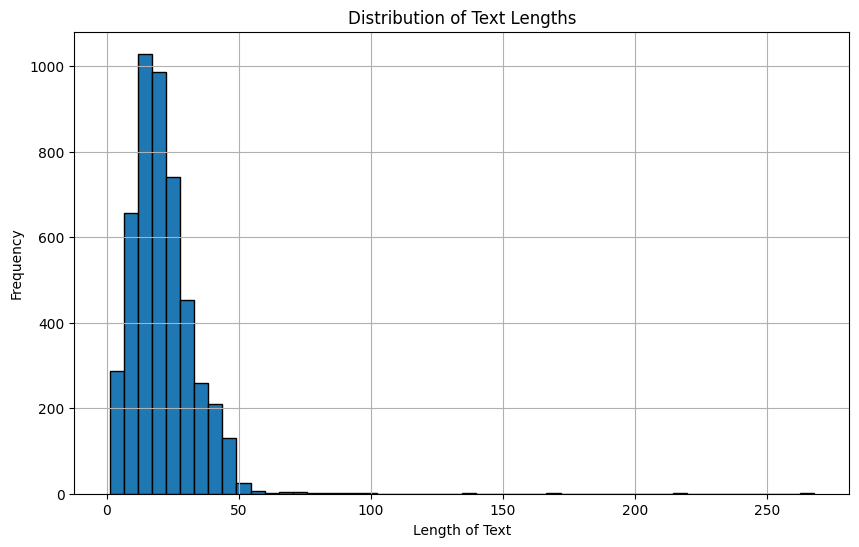

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(words_count, bins=50, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Model Ujicoba

### Model IndoTweet - 16

In [11]:
from transformers import AutoTokenizer
from datasets import load_dataset

model_checkpoint = "indolem/indobertweet-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_data = tokenizer(train['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
train_data = dict(train_data)  # Because the tokenizer returns a dict subclass
train_labels = np.array(train["label"])

val_data = tokenizer(val['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
val_data = dict(val_data)  # Because the tokenizer returns a dict subclass
val_labels = np.array(val["label"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
from transformers import TFAutoModelForSequenceClassification

with strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, from_pt=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 2 * strategy.num_replicas_in_sync

tf_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset = tf_dataset.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(16,), dtype=tf.int64, name=None))>

In [14]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 2 * strategy.num_replicas_in_sync

tf_dataset_val = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=len(tf_dataset_val), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset_val = tf_dataset_val.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset_val

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(16,), dtype=tf.int64, name=None))>

In [15]:
# saved_filepath = '/content/drive/MyDrive/Satria Data pt 2/Semifinal/Model/IndoTweet_32/checkpoint-IndoTweet_32'

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=saved_filepath,  # Path to save the model file
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     save_best_only=True,  # Save only the best model
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     save_weights_only=True,  # Save only the model weights
#     verbose=1  # Verbosity mode
# )

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     patience=3,  # Number of epochs with no improvement after which training will be stopped
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     verbose=1  # Verbosity mode
# )


In [16]:
import time

start_time_serial = time.time()
model.fit(tf_dataset, epochs=5, validation_data=tf_dataset_val)
end_time_serial = time.time()

Epoch 1/5
300/300 [==============================] - 102s 92ms/step - loss: 0.5264 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.4055 - val_sparse_categorical_accuracy: 0.8033
Epoch 2/5
300/300 [==============================] - 23s 77ms/step - loss: 0.3492 - sparse_categorical_accuracy: 0.8325 - val_loss: 0.3859 - val_sparse_categorical_accuracy: 0.8108
Epoch 3/5
300/300 [==============================] - 23s 76ms/step - loss: 0.2914 - sparse_categorical_accuracy: 0.8673 - val_loss: 0.3772 - val_sparse_categorical_accuracy: 0.8175
Epoch 4/5
300/300 [==============================] - 23s 76ms/step - loss: 0.2393 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.3899 - val_sparse_categorical_accuracy: 0.8200
Epoch 5/5
300/300 [==============================] - 23s 77ms/step - loss: 0.1746 - sparse_categorical_accuracy: 0.9323 - val_loss: 0.4566 - val_sparse_categorical_accuracy: 0.8142


### Model IndoTweet - 24

In [12]:
from transformers import AutoTokenizer
from datasets import load_dataset

model_checkpoint = "indolem/indobertweet-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_data = tokenizer(train['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
train_data = dict(train_data)  # Because the tokenizer returns a dict subclass
train_labels = np.array(train["label"])

val_data = tokenizer(val['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
val_data = dict(val_data)  # Because the tokenizer returns a dict subclass
val_labels = np.array(val["label"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
from transformers import TFAutoModelForSequenceClassification

with strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, from_pt=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 3 * strategy.num_replicas_in_sync

tf_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset = tf_dataset.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(24,), dtype=tf.int64, name=None))>

In [15]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 3 * strategy.num_replicas_in_sync

tf_dataset_val = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=len(tf_dataset_val), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset_val = tf_dataset_val.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset_val

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(24,), dtype=tf.int64, name=None))>

In [16]:
# saved_filepath = '/content/drive/MyDrive/Satria Data pt 2/Semifinal/Model/IndoTweet_24/checkpoint-IndoTweet_24'

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=saved_filepath,  # Path to save the model file
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     save_best_only=True,  # Save only the best model
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     save_weights_only=True,  # Save only the model weights
#     verbose=1  # Verbosity mode
# )

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     patience=3,  # Number of epochs with no improvement after which training will be stopped
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     verbose=1  # Verbosity mode
# )
# , callbacks=[checkpoint_callback, early_stopping_callback]

In [17]:
import time

start_time_serial = time.time()
model.fit(tf_dataset, epochs=5, validation_data=tf_dataset_val)
end_time_serial = time.time()

Epoch 1/5
200/200 [==============================] - 96s 107ms/step - loss: 0.5354 - sparse_categorical_accuracy: 0.7085 - val_loss: 0.4221 - val_sparse_categorical_accuracy: 0.7942
Epoch 2/5
200/200 [==============================] - 16s 82ms/step - loss: 0.3709 - sparse_categorical_accuracy: 0.8213 - val_loss: 0.3863 - val_sparse_categorical_accuracy: 0.8067
Epoch 3/5
200/200 [==============================] - 16s 78ms/step - loss: 0.3074 - sparse_categorical_accuracy: 0.8569 - val_loss: 0.3879 - val_sparse_categorical_accuracy: 0.8125
Epoch 4/5
200/200 [==============================] - 16s 79ms/step - loss: 0.2653 - sparse_categorical_accuracy: 0.8852 - val_loss: 0.3986 - val_sparse_categorical_accuracy: 0.8150
Epoch 5/5
200/200 [==============================] - 16s 81ms/step - loss: 0.2128 - sparse_categorical_accuracy: 0.9140 - val_loss: 0.4357 - val_sparse_categorical_accuracy: 0.8117


### Model IndoTweet - 32

In [11]:
from transformers import AutoTokenizer
from datasets import load_dataset

model_checkpoint = "indolem/indobertweet-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_data = tokenizer(train['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
train_data = dict(train_data)  # Because the tokenizer returns a dict subclass
train_labels = np.array(train["label"])

val_data = tokenizer(val['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
val_data = dict(val_data)  # Because the tokenizer returns a dict subclass
val_labels = np.array(val["label"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
from transformers import TFAutoModelForSequenceClassification

with strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, from_pt=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 4 * strategy.num_replicas_in_sync

tf_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset = tf_dataset.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

In [14]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 4 * strategy.num_replicas_in_sync

tf_dataset_val = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=len(tf_dataset_val), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset_val = tf_dataset_val.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset_val

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

In [15]:
# saved_filepath = '/content/drive/MyDrive/Satria Data pt 2/Semifinal/Model/IndoTweet_24/checkpoint-IndoTweet_24'

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=saved_filepath,  # Path to save the model file
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     save_best_only=True,  # Save only the best model
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     save_weights_only=True,  # Save only the model weights
#     verbose=1  # Verbosity mode
# )

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     patience=3,  # Number of epochs with no improvement after which training will be stopped
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     verbose=1  # Verbosity mode
# )


In [16]:
import time

start_time_serial = time.time()
model.fit(tf_dataset, epochs=5, validation_data=tf_dataset_val)
end_time_serial = time.time()

Epoch 1/5
150/150 [==============================] - 92s 127ms/step - loss: 0.5606 - sparse_categorical_accuracy: 0.7038 - val_loss: 0.4147 - val_sparse_categorical_accuracy: 0.7939
Epoch 2/5
150/150 [==============================] - 13s 85ms/step - loss: 0.3697 - sparse_categorical_accuracy: 0.8158 - val_loss: 0.3686 - val_sparse_categorical_accuracy: 0.8100
Epoch 3/5
150/150 [==============================] - 13s 84ms/step - loss: 0.3078 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.3564 - val_sparse_categorical_accuracy: 0.8294
Epoch 4/5
150/150 [==============================] - 13s 88ms/step - loss: 0.2560 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.3800 - val_sparse_categorical_accuracy: 0.8201
Epoch 5/5
150/150 [==============================] - 13s 86ms/step - loss: 0.1984 - sparse_categorical_accuracy: 0.9215 - val_loss: 0.4307 - val_sparse_categorical_accuracy: 0.8269


### Model IndoBERT - 16

In [11]:
from transformers import AutoTokenizer
from datasets import load_dataset

model_checkpoint = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_data = tokenizer(train['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
train_data = dict(train_data)  # Because the tokenizer returns a dict subclass
train_labels = np.array(train["label"])

val_data = tokenizer(val['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
val_data = dict(val_data)  # Because the tokenizer returns a dict subclass
val_labels = np.array(val["label"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
from transformers import TFAutoModelForSequenceClassification

with strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 2 * strategy.num_replicas_in_sync

tf_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset = tf_dataset.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(16,), dtype=tf.int64, name=None))>

In [14]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 2 * strategy.num_replicas_in_sync

tf_dataset_val = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=len(tf_dataset_val), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset_val = tf_dataset_val.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset_val

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(16,), dtype=tf.int64, name=None))>

In [15]:
# saved_filepath = '/content/drive/MyDrive/Satria Data pt 2/Semifinal/Model/IndoTweet_24/checkpoint-IndoTweet_24'

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=saved_filepath,  # Path to save the model file
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     save_best_only=True,  # Save only the best model
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     save_weights_only=True,  # Save only the model weights
#     verbose=1  # Verbosity mode
# )

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     patience=3,  # Number of epochs with no improvement after which training will be stopped
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     verbose=1  # Verbosity mode
# )


In [16]:
import time

start_time_serial = time.time()
model.fit(tf_dataset, epochs=5, validation_data=tf_dataset_val)
end_time_serial = time.time()

Epoch 1/5
300/300 [==============================] - 102s 98ms/step - loss: 0.5330 - sparse_categorical_accuracy: 0.7365 - val_loss: 0.3811 - val_sparse_categorical_accuracy: 0.8133
Epoch 2/5
300/300 [==============================] - 23s 78ms/step - loss: 0.3407 - sparse_categorical_accuracy: 0.8427 - val_loss: 0.3709 - val_sparse_categorical_accuracy: 0.8092
Epoch 3/5
300/300 [==============================] - 24s 79ms/step - loss: 0.2599 - sparse_categorical_accuracy: 0.8917 - val_loss: 0.4140 - val_sparse_categorical_accuracy: 0.8117
Epoch 4/5
300/300 [==============================] - 24s 80ms/step - loss: 0.1589 - sparse_categorical_accuracy: 0.9431 - val_loss: 0.5678 - val_sparse_categorical_accuracy: 0.7867
Epoch 5/5
300/300 [==============================] - 24s 79ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.6393 - val_sparse_categorical_accuracy: 0.8058


### Model IndoBERT - 24

In [11]:
from transformers import AutoTokenizer
from datasets import load_dataset

model_checkpoint = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_data = tokenizer(train['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
train_data = dict(train_data)  # Because the tokenizer returns a dict subclass
train_labels = np.array(train["label"])

val_data = tokenizer(val['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
val_data = dict(val_data)  # Because the tokenizer returns a dict subclass
val_labels = np.array(val["label"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
from transformers import TFAutoModelForSequenceClassification

with strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 3 * strategy.num_replicas_in_sync

tf_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset = tf_dataset.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(24,), dtype=tf.int64, name=None))>

In [14]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 3 * strategy.num_replicas_in_sync

tf_dataset_val = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=len(tf_dataset_val), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset_val = tf_dataset_val.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset_val

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(24, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(24,), dtype=tf.int64, name=None))>

In [15]:
# saved_filepath = '/content/drive/MyDrive/Satria Data pt 2/Semifinal/Model/IndoTweet_24/checkpoint-IndoTweet_24'

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=saved_filepath,  # Path to save the model file
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     save_best_only=True,  # Save only the best model
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     save_weights_only=True,  # Save only the model weights
#     verbose=1  # Verbosity mode
# )

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     patience=3,  # Number of epochs with no improvement after which training will be stopped
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     verbose=1  # Verbosity mode
# )


In [16]:
import time

start_time_serial = time.time()
model.fit(tf_dataset, epochs=5, validation_data=tf_dataset_val)
end_time_serial = time.time()

Epoch 1/5
200/200 [==============================] - 99s 109ms/step - loss: 0.5383 - sparse_categorical_accuracy: 0.7258 - val_loss: 0.3824 - val_sparse_categorical_accuracy: 0.8142
Epoch 2/5
200/200 [==============================] - 17s 85ms/step - loss: 0.3614 - sparse_categorical_accuracy: 0.8260 - val_loss: 0.4277 - val_sparse_categorical_accuracy: 0.7950
Epoch 3/5
200/200 [==============================] - 17s 84ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.8660 - val_loss: 0.3778 - val_sparse_categorical_accuracy: 0.8150
Epoch 4/5
200/200 [==============================] - 16s 82ms/step - loss: 0.2266 - sparse_categorical_accuracy: 0.9048 - val_loss: 0.4167 - val_sparse_categorical_accuracy: 0.8033
Epoch 5/5
200/200 [==============================] - 17s 83ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9535 - val_loss: 0.6475 - val_sparse_categorical_accuracy: 0.7950


### Model IndoBERT - 32

In [11]:
from transformers import AutoTokenizer
from datasets import load_dataset

model_checkpoint = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_data = tokenizer(train['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
train_data = dict(train_data)  # Because the tokenizer returns a dict subclass
train_labels = np.array(train["label"])

val_data = tokenizer(val['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
val_data = dict(val_data)  # Because the tokenizer returns a dict subclass
val_labels = np.array(val["label"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
from transformers import TFAutoModelForSequenceClassification

with strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, from_pt=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 4 * strategy.num_replicas_in_sync

tf_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset = tf_dataset.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

In [14]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 4 * strategy.num_replicas_in_sync

tf_dataset_val = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=len(tf_dataset_val), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset_val = tf_dataset_val.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset_val

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

In [15]:
# saved_filepath = '/content/drive/MyDrive/Satria Data pt 2/Semifinal/Model/IndoTweet_24/checkpoint-IndoTweet_24'

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=saved_filepath,  # Path to save the model file
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     save_best_only=True,  # Save only the best model
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     save_weights_only=True,  # Save only the model weights
#     verbose=1  # Verbosity mode
# )

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_sparse_categorical_accuracy',  # Metric to monitor
#     patience=3,  # Number of epochs with no improvement after which training will be stopped
#     mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
#     verbose=1  # Verbosity mode
# )


In [16]:
import time

start_time_serial = time.time()
model.fit(tf_dataset, epochs=5, validation_data=tf_dataset_val)
end_time_serial = time.time()

Epoch 1/5
150/150 [==============================] - 94s 130ms/step - loss: 0.5776 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.4024 - val_sparse_categorical_accuracy: 0.8074
Epoch 2/5
150/150 [==============================] - 14s 91ms/step - loss: 0.3573 - sparse_categorical_accuracy: 0.8246 - val_loss: 0.4095 - val_sparse_categorical_accuracy: 0.7981
Epoch 3/5
150/150 [==============================] - 13s 89ms/step - loss: 0.3032 - sparse_categorical_accuracy: 0.8633 - val_loss: 0.3850 - val_sparse_categorical_accuracy: 0.8091
Epoch 4/5
150/150 [==============================] - 13s 89ms/step - loss: 0.2341 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.4057 - val_sparse_categorical_accuracy: 0.8125
Epoch 5/5
150/150 [==============================] - 14s 91ms/step - loss: 0.1409 - sparse_categorical_accuracy: 0.9485 - val_loss: 0.5497 - val_sparse_categorical_accuracy: 0.7880


## Inference Data

### Model IndoTweet - 32

In [11]:
from transformers import AutoTokenizer
from datasets import load_dataset

model_checkpoint = "indolem/indobertweet-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_data = tokenizer(train['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
train_data = dict(train_data)  # Because the tokenizer returns a dict subclass
train_labels = np.array(train["label"])

val_data = tokenizer(val['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
val_data = dict(val_data)  # Because the tokenizer returns a dict subclass
val_labels = np.array(val["label"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
from transformers import TFAutoModelForSequenceClassification

with strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, from_pt=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 4 * strategy.num_replicas_in_sync

tf_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset = tf_dataset.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

In [14]:
# The batch size will be split among TPU workers
# so we scale it up based on how many of them there are
BATCH_SIZE = 4 * strategy.num_replicas_in_sync

tf_dataset_val = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=len(tf_dataset_val), seed=seed_value)
# You should use drop_remainder on TPU where possible, because a change in the
# batch size will require a new XLA compilation
tf_dataset_val = tf_dataset_val.batch(BATCH_SIZE, drop_remainder=True)

tf_dataset_val

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(32, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

In [15]:
saved_filepath = '/content/drive/MyDrive/Satria Data pt 2/Semifinal/Model/IndoTweet_32/checkpoint-IndoTweet_32'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=saved_filepath,  # Path to save the model file
    monitor='val_sparse_categorical_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
    save_weights_only=True,  # Save only the model weights
    verbose=1  # Verbosity mode
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy',  # Metric to monitor
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    mode='max',  # Mode to determine if the metric is improving (use 'min' for loss)
    verbose=1  # Verbosity mode
)


In [16]:
import time

start_time_serial = time.time()
model.fit(tf_dataset, epochs=5, validation_data=tf_dataset_val, callbacks=[checkpoint_callback, early_stopping_callback])
end_time_serial = time.time()

Epoch 1/5
150/150 [==============================] - ETA: 0s - loss: 0.5566 - sparse_categorical_accuracy: 0.6975
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.79392, saving model to /content/drive/MyDrive/Satria Data pt 2/Semifinal/Model/IndoTweet_32/checkpoint-IndoTweet_32
150/150 [==============================] - 102s 182ms/step - loss: 0.5566 - sparse_categorical_accuracy: 0.6975 - val_loss: 0.4202 - val_sparse_categorical_accuracy: 0.7939
Epoch 2/5
150/150 [==============================] - ETA: 0s - loss: 0.3741 - sparse_categorical_accuracy: 0.8154
Epoch 2: val_sparse_categorical_accuracy improved from 0.79392 to 0.81166, saving model to /content/drive/MyDrive/Satria Data pt 2/Semifinal/Model/IndoTweet_32/checkpoint-IndoTweet_32
150/150 [==============================] - 20s 135ms/step - loss: 0.3741 - sparse_categorical_accuracy: 0.8154 - val_loss: 0.3798 - val_sparse_categorical_accuracy: 0.8117
Epoch 3/5
150/150 [==============================] - ETA: 0s -

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt

# cm = confusion_matrix(val_labels, predicted_classes)


# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive 1', 'Negative 0'], yticklabels=['Positive 1', 'Negative 0'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()


# report = classification_report(val_labels, predicted_classes, digits=5)
# print(report)

### Predict

In [17]:
from transformers import TFAutoModelForSequenceClassification

with strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, from_pt=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.load_weights(saved_filepath)

loss, accuracy = model.evaluate(tf_dataset_val)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


37/37 [==============================] - 8s 15ms/step - loss: 0.3743 - sparse_categorical_accuracy: 0.8277
Validation loss: 0.3743038475513458
Validation accuracy: 0.8277027010917664


In [18]:
result_df = pd.read_pickle('/content/drive/MyDrive/Satria Data pt 2/Semifinal/Dataset/dav/result_df_clean.pkl')
test_df = result_df[['username', 'content']]
test_df.head()

,username,content
0,@be9+Qm5EsBY7VLxMEGgBlOYaT0KrMsiQQLzN5iG2hOY=,
1,@JVWxyA2fM/S2B0bN/n/buYbHxNqUC91UUX6ShBzub+I=,!
2,@7jB3OiFFcymo1DxD4GO8wR2tuWnQLk+nRHfZmLs1iHo=,! deretan pesohor dan selebriti yang dukung ga...
3,@CDJsmOeil3IHVzBWFKLBs21n0Q2nBvRird0Wb9yxync=,!! iya pakk salah strategii next nya di perbai...
4,@X4DJ8WnurWZZIm9IizCEzcdSPvFwGF1pnHnLk1YMgWk=,!! katanya sudah dikembalikan oleh !!


In [19]:
from datasets import Dataset

test = Dataset.from_pandas(test_df)

In [20]:
from transformers import AutoTokenizer
from datasets import load_dataset

model_checkpoint = "indolem/indobertweet-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

test_data = tokenizer(test['content'], padding='max_length', truncation=True, max_length=64, return_tensors="np")
test_data = dict(test_data)  # Because the tokenizer returns a dict subclass

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
predictions = model.predict(test_data)
predictions

67538/67538 [==============================] - 1226s 18ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[ 0.17989245, -0.06349184],
       [-0.01248266, -0.11125045],
       [ 1.6361483 , -1.6288992 ],
       ...,
       [-0.56802964,  0.39536303],
       [-0.590188  ,  0.12345245],
       [ 0.52883947, -0.766462  ]], dtype=float32), hidden_states=None, attentions=None)

In [22]:
import pickle

with open('/content/drive/MyDrive/Satria Data pt 2/Semifinal/Predictons/pred_indotweet_v2.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [23]:
prob_pred = tf.nn.softmax(predictions.logits, axis=-1).numpy()
predicted_classes = np.argmax(prob_pred, axis=-1)
predicted_probabilities = np.max(prob_pred, axis=-1)

In [24]:
result_df['predicted_buzzer_indotweet'] = predicted_classes

In [25]:
with open('/content/drive/MyDrive/Satria Data pt 2/Semifinal/Predictons/pred_indotweet.pkl', 'rb') as f:
    predictions_lama = pickle.load(f)

prob_pred_lama = tf.nn.softmax(predictions_lama.logits, axis=-1).numpy()
predicted_classes_lama = np.argmax(prob_pred_lama, axis=-1)
predicted_probabilities_lama = np.max(prob_pred_lama, axis=-1)

In [26]:
import numpy as np

# Convert lists to NumPy arrays
arr1 = np.array(predicted_classes)
arr2 = np.array(predicted_classes_lama)

# Count number of matches (where elements are the same)
num_matches = np.sum(arr1 == arr2)

# Print or use num_matches
print(f"Number of matches: {num_matches}")


Number of matches: 1858461


##### Cek Predictions

In [ ]:
result_df.loc[result_df['predicted_buzzer_indotweet'] == 1].sample(100, random_state=42)

,content,created_at,username,tcode,num_retweets,frn_cnt,flw_cnt,sts_cnt,loc,lst_cnt,lang,appearance_count,nama_re,predicted_buzzer_indotweet
1323418,pendukungnya sedang mencuci piring hingga kinc...,2024-01-10 09:55:32+00:00,@AJpfp1dN+Rmop7feTApn/dM3H2CwnFL1V+Yt7Wrht3A=,reply,0,32.0,28.0,810.0,-,0.0,id,1,-,1
415597,"dul, coba nyebokinnya sambil dijilat.. tainya ...",2024-01-21 17:23:07+00:00,@1Dhh7Xh1+yXKPT7+5W4Crjk0A4CwXdsq/xfnl6j9B1k=,reply,0,126.0,41.0,378.0,World,2.0,id,1,-,1
842585,kamu kalau nonton bisa lihat dan dengar dasar ...,2024-01-07 20:15:08+00:00,@B+UK4LfW180yJi8NT0jFo1HM9Wl0MMLcyllc5bRDVz8=,reply,0,1025.0,364.0,15246.0,"Bandung, Jawa Barat",1.0,id,1,-,1
1885055,tau yg bikin orang2 pada males milih 02? bukan...,2024-01-31 17:34:39+00:00,@eJBfMaHKGAS3X3J8b0ccdctdmQ1OVcLk5Nr4RVYx2Po=,reply,0,12.0,2.0,195.0,-,0.0,id,1,-,1
879707,kebersamaan ganjar-mahfud dan slank menciptaka...,2024-01-21 08:11:02+00:00,@JyCiX0zIhWliPQLVPKM5bSO3pOTFsJIvoC+iNOxnR9M=,mention,0,34.0,10.0,1386.0,Jambi,0.0,id,1,-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287527,"pas itu pak ganjar topengnya setan, kayak klub...",2024-01-09 12:31:16+00:00,@YNZvBUKKtRxExytAMuTXzzpGNGpAvIC4Q3ZBFfeXBQg=,reply,0,3291.0,4720.0,17084.0,"Manchester, England",2.0,id,1,-,1
82246,"also prabowo ""ndasmu etik, goblok, otaknya kur...",2024-01-21 03:19:21+00:00,@qg/vcjgnCcKtqE+TYPuBizut/yfyuG6Qroh85paPHes=,reply,0,115.0,7.0,1099.0,Indonesia,1.0,id,1,-,1
319875,"dalam kebersamaan ganjar pranowo mahfud md, in...",2024-01-22 13:10:13+00:00,@srdqcHagk2sGq/jdVpJ9PQugASwUQU5fRq6xUlpWK/M=,mention,0,2.0,3.0,5487.0,-,0.0,id,1,-,1
1884172,tas tes semoga ganjar-mahfud selalu memberi du...,2024-01-07 13:11:46+00:00,@KgdEqtj9C0oqRLvvIGz+opk3hppd8SvOOFtojeqLeLE=,mention,0,53.0,32.0,1230.0,Sabang,0.0,id,1,-,1


In [ ]:
result_df.loc[result_df['predicted_buzzer_indotweet'] == 0].sample(100, random_state=42)

,content,created_at,username,tcode,num_retweets,frn_cnt,flw_cnt,sts_cnt,loc,lst_cnt,lang,appearance_count,nama_re,predicted_buzzer_indotweet
2014094,"yakin nih, gengs? percaya sama strategi 'ngele...",2024-01-08 22:46:33+00:00,@uUyh6hIoPekQJTSnMc5IJDMht0qDafceXjTDWcjt7QA=,mention,0,59.000000,37.000000,131.000000,Bima,0.000000,id,1,-,0
1079451,masyaallah semoga pak ganjar bisa menjadi pres...,2024-01-16 22:08:26+00:00,@WVT2D3kciAwBxI+NHPnDa/cXbYhRh9GmurSfUj54Fic=,reply,0,1.000000,3.000000,382.000000,-,0.000000,id,1,-,0
169275,baca dong pak,2024-01-23 08:19:20+00:00,@ssH5wrz9tV2AOnJ4y6D9YsMQeqnnP+Lzsvx4SC5Z4Us=,mention,0,328.000000,177.500000,8062.000000,-,0.500000,id,2,-,0
1607243,rt pak ganjar pranowo menganggap kritikan seba...,2024-01-19 15:19:03+00:00,@7Lwm94rIM1jxl9ocnegacugfBjOTAmWUIw3ePRBDUwU=,rt,4,1575.666667,13556.333333,84096.666667,-,2.666667,id,3,Denokamu,0
1492247,rt anies malah di bawah 5 ya...sadis ððð...,2024-01-08 12:57:24+00:00,@JZ52q3B7tUQrpD1ZKwHrJK8VPDxiIjIMBHgQhRQ/c78=,rt,1,2345.000000,19360.000000,66535.000000,Indonesia,24.000000,id,1,RekjanS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805052,"setuju sih, gue hampir kemakan narasi beliau b...",2024-01-31 03:01:50+00:00,@2bRJl5P3EZVgnjVn6Es2g5j4aZW4Xs57EDeyK2Lv7mw=,reply,0,144.000000,66.000000,4246.000000,-,0.000000,id,1,-,0
1364196,prabagoes: sangat banyak alasan mengapa kita m...,2024-01-11 22:02:10+00:00,@nC0etgOvRmkywTWwNZ/aaU+N2dZbTkBa0hczAWy/6oY=,mention,0,0.000000,1.000000,292.000000,-,0.000000,id,1,-,0
974475,ktp sakti ganjar-mahfud!!!! berbagai macam man...,2024-01-09 04:54:01+00:00,@fAWl1Ijkp1vbayHuxCTWNNOlWZEQLMgvtrqq1rVZ9Ts=,mention,0,11.523810,1.809524,296.619048,-,0.000000,id,21,-,0
1751047,semakin optimis pak ganjar menang ngobrol bar3...,2024-01-13 10:30:00+00:00,@yXihmyAT19JcXQeZD9+FzV1eEYCGY9X3SZn4LZKOslI=,mention,0,27.000000,27.000000,99.000000,"Quantico, VA",0.000000,id,1,-,0


In [ ]:
result_df.loc[result_df['predicted_buzzer_indotweet'] == 0].shape

(1173243, 14)

In [ ]:
result_df.loc[result_df['predicted_buzzer_indotweet'] == 1].shape

(987956, 14)